This notebook supplements the manuscript "Data-driven modeling reveals a universal dynamic underlying the COVID-19 pandemic under social distancing" by Robert Marsland III and Pankaj Mehta.

In this work, we show that the cumulative fatalities $N(t)$ for every region with more than 500 deaths as of April 15, 2020 is well-described by the function:
\begin{align}
N(t) = N_{\rm max}\Phi\left(\frac{t-t_h}{\sigma}\right),
\end{align}
where
\begin{align}
\Phi(t) &= {1 \over \sqrt{2\pi}} \int_{-\infty}^t e^{-x^2/2}\,dx
\end{align}
is the cumulative normal distribution. The same functional form provides a good fit to the cumulative number of confirmed cases for most countries with sufficient data. This model has two key parameters, the final total number of fatalities (or cases) $N_{\rm max}$, and the infection timescale $\sigma$. The third parameter $t_h$, sets the overall location of the infection curve on the time axis. 

The first cell of this notebook loads the current case and fatality data from the [Johns Hopkins github repository](https://github.com/CSSEGISandData/COVID-19) along with the best-fit values and confidence bounds for the three fitting parameters using data through April 15, 2020, and a set of functions for fitting, analyzing and simulating the data. Example code is provided for plotting the predictions, and will soon also be provided for making new predictions, and running simulations.

We emphasize that the confidence intervals shown here are <em>lower bounds</em> on the true amount of uncertainty. These intervals are calculated under the assumption that the data is accurately described by the fitting function given above, with no changes in parameter values, and with all deviations from this function due to random multiplicative noise. The confidence intervals <em>do not</em> account for possible future changes in social policy, or for systematic deviations from the fitting function that may arise at late times.

# Plot predictions

To plot the live data with the predictions made on April 15, replace the arguments of the "plot_region" function with the country and province/state of interest. Country-level data is accessed by using 'NaN' for the second argument.

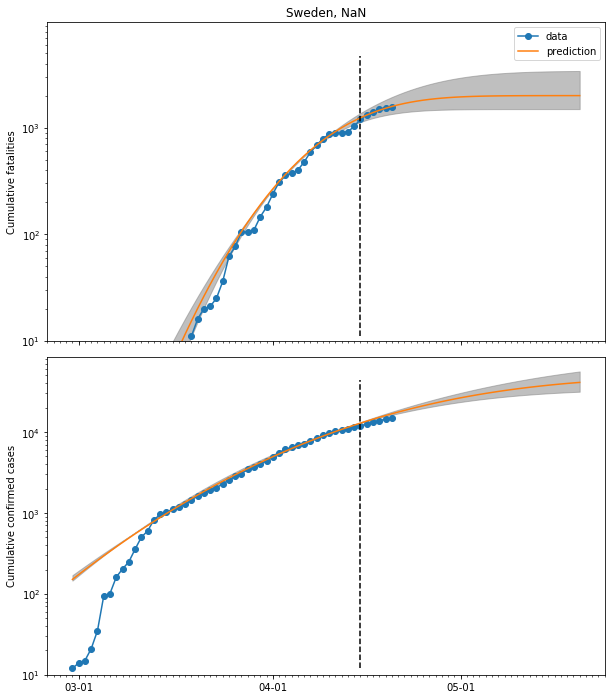

In [6]:
from covid_plotting import *
#Replace arguments with the country and province/state of interest:
plot_region('Sweden','NaN',forecast_days=30) 
#For country-level data, use 'NaN' for the second argument.
plt.show()

# Print parameters

To access the parameters for a given region, replace the two strings in the line below with the country and state/province of interest.

For fatalities, use:

In [7]:
predictions_deaths.loc['Sweden','NaN']

Nmax                      2007.23
Nmax_low                  1499.11
Nmax_high                 3433.77
sigma                     9.88884
sigma_low                 8.60252
sigma_high                11.9405
th            2020-04-12 00:00:00
th_low        2020-04-09 00:00:00
th_high       2020-04-18 00:00:00
Name: (Sweden, NaN), dtype: object

For cases, use:

In [7]:
predictions_cases.loc['Sweden','NaN']

Nmax                      49328.6
Nmax_low                  33886.3
Nmax_high                 85215.3
sigma                     21.8862
sigma_low                 19.7903
sigma_high                24.6654
th            2020-04-29 00:00:00
th_low        2020-04-21 00:00:00
th_high       2020-05-10 00:00:00
Name: (Sweden, NaN), dtype: object

The complete spreadsheets can also be downloaded from the "output" folder of [the github repository](https://github.com/Emergent-Behaviors-in-Biology/covid19).

# Make new predictions

Coming soon!

# Run simulation

Coming soon!